# Minimal code for a single F layer solution using our tooling

Here we calculate everything but avoid the outer self consistent loop

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup

In [2]:
# Flayer setup
f_layer_thickness = 200_000 # m
delta_t_icb = 50 # K below projected adiabat
xfe_outer_core = 0.95 # mol frac Fe
xfe_icb = 0.949 # mol frac Fe

# Transport and growth properties
growth_prefactor = 150.0 # (k0) m/s
chemical_diffusivity = 1.0e-9
thermal_conductivity = 100.0
kinematic_viscosity = 1.0e-6

# Nucleation
i0 = 1.0e-10 # (I0) # s^-1m^-3
surf_energy = 1.08e-2 # (gamma) J/m^2
wetting_angle = 180.0 # degrees

# Numerics
number_of_analysis_points = 100
number_of_knots = 5

# Sensible defaults below
hetrogeneous_radius=None
r_icb=1221.5E3
r_cmb=3480.0E3
gruneisen_parameter=1.5
start_time=0.0
max_time=1.0E12
max_rel_error=1.0E-5
max_absolute_error=1.0E-8
verbose=False
opt_mode='both'

In [3]:
# Setup the f-layer

# Derived radii
r_flayer_top = r_icb + f_layer_thickness
        
# Discretisation points
nucleation_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
analysis_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
knott_radii = np.linspace(r_icb, r_flayer_top, number_of_knots)

temperature_function, adiabatic_temperature_function, flayer_temperature_function, t_func_creator, composition_function, \
        pressure_function, gravity_function, x_func_creator = layer_setup.setup_flayer_functions(r_icb, r_cmb, f_layer_thickness, 
                                                      gruneisen_parameter, delta_t_icb, xfe_outer_core, xfe_icb, knott_radii)

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


In [4]:
rs = np.linspace(r_icb, r_flayer_top+100.0E3)

# Check PREM works ... and print some interesting values
prem = earth_model.Prem()
print("Pressure at ICB:", prem.pressure(r_icb/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(r_flayer_top/1000.0), "GPa")
print("g at ICB:", prem.gravity(r_icb/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(r_flayer_top/1000.0), "m/s**2")

# Find the liquidus
tl = feot.find_liquidus(composition_function(rs), pressure_function(rs))

# Find the liquid density

liquid_density, _, _, solid_density, _, _ = feot.densities(composition_function(rs), pressure_function(rs),
                                                           temperature_function(rs))

# This is for a well mixed core extended down 
adiabatic_liquid_density, _, _, adiabatic_solid_density, _, _ = feot.densities(xfe_outer_core, pressure_function(rs), 
                                                                               adiabatic_temperature_function(rs))

print("Liquid density at ICB:", liquid_density[0], "Kg/m^3")
print("Liquid density at top of F-layer", liquid_density[-1], "Kg/m^3")
print("Liquid density along adiabat at ICB:", adiabatic_liquid_density[0], "Kg/m^3")
print("Liquid density along adiabat at top of F-layer", adiabatic_liquid_density[-1], "Kg/m^3")

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Liquid density at ICB: 13094.162907668073 Kg/m^3
Liquid density at top of F-layer 12902.300312084477 Kg/m^3
Liquid density along adiabat at ICB: 13092.292163636042 Kg/m^3
Liquid density along adiabat at top of F-layer 12902.300312084477 Kg/m^3


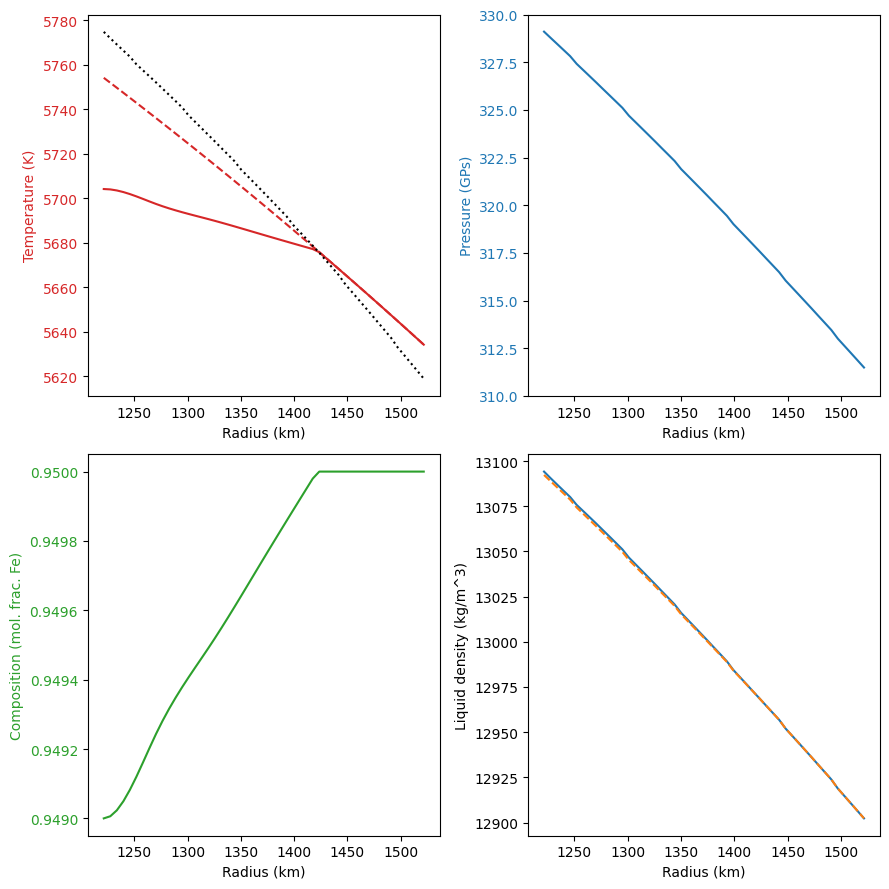

In [5]:

# Plot the F-layer setup alongside the liquidus
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(9,9), tight_layout=True)

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, temperature_function(rs), color=color)
ax1.plot(rs/1000.0, adiabatic_temperature_function(rs), color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])
 

color = 'tab:blue'
ax2.set_xlabel('Radius (km)')
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, pressure_function(rs), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([310, 330])

color = 'tab:green'
ax3.set_xlabel('Radius (km)')
ax3.set_ylabel('Composition (mol. frac. Fe)', color=color)  
ax3.plot(rs/1000.0, composition_function(rs), color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4.set_xlabel('Radius (km)')
ax4.set_ylabel('Liquid density (kg/m^3)')  
ax4.plot(rs/1000.0, liquid_density)
ax4.plot(rs/1000.0, adiabatic_liquid_density, ls='--')
#ax4.plot(rs/1000.0, solid_density, ls=':')
ax4.tick_params(axis='y')

fig.tight_layout()  
plt.show()

In [6]:
def estimate_brunt_vaisala_frequency(r_top, r_bot, tfunc, atfunc, xfunc, gfunc, pfunc):
    """
    Derive an estimate for the Brunt Vaisala frequency for a layer by taking differences
    
    We assume we can write:
    
       N_BV^2 = -(g_m/rho_m) (rho'_t - rho'_b)/(R_t - R_b)
       
    where t, m and b are at the top, middle and bottom of the layer and rho' is the difference
    in density between an adiabatic state and the real density. For the adiabatic state we follow
    the temperature down an adiabat and assume the composition is well mixed (i.e. assume it is 
    the same as the bulk outer core).
    
    Returns N and N^2, if N^2 is negative we return a complex value.
    """
    r_m = r_bot + (r_top - r_bot)/2.0
    # Don't need the absolute density at the top of the layer
    rho_b, _, _, _, _, _ = feot.densities(xfunc(r_bot), pfunc(r_bot), tfunc(r_bot))
    rho_m, _, _, _, _, _ = feot.densities(xfunc(r_m), pfunc(r_m), tfunc(r_m))
    # Our reference at the top is the same as the real density (because we construct
    # the layer that way), the reference at the bottom follows the adiabatic temperature
    # but uses the composition from the top (well mixed)
    ref_rho_b, _, _, _, _, _ = feot.densities(xfunc(r_top), pfunc(r_bot), atfunc(r_bot))
        
    N2 = -1.0 * (gfunc(r_m) / rho_m) * (0.0 - (rho_b - ref_rho_b)) / (r_top - r_bot)
    
    if N2 >= 0.0:
        Nbv = np.sqrt(N2)
    else:
        Nbv = np.sqrt((N2 + 0j))
    return Nbv, N2

In [7]:
estimate_brunt_vaisala_frequency(r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
                                 composition_function, gravity_function, pressure_function)

(5.810689475693938e-05, 3.3764112182940293e-09)

In [8]:
# WARNING - uses data from envionment

def evaluate_layer(delta_t_icb, xfe_icb):
        
    temperature_function, adiabatic_temperature_function, flayer_temperature_function, t_func_creator, composition_function, \
        pressure_function, gravity_function, x_func_creator = layer_setup.setup_flayer_functions(r_icb, r_cmb, f_layer_thickness, 
                                                      gruneisen_parameter, delta_t_icb, xfe_outer_core, xfe_icb, knott_radii)
    
    # Get Nbv**2 to establish stability
    _, N2 = estimate_brunt_vaisala_frequency(r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
                                 composition_function, gravity_function, pressure_function)

    return N2

In [9]:
sub_adiabatic_ts = np.linspace(20, 60, 5)
feconts = np.linspace(0.945, 0.95, 5)

for deltat in sub_adiabatic_ts:
    for feicb in feconts:
        N2 = evaluate_layer(deltat, feicb)
        print(f"{deltat} {feicb} {N2}")

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


20.0 0.945 -2.7879462229992318e-08
20.0 0.9462499999999999 -1.9947470793516695e-08
20.0 0.9475 -1.2007242996128094e-08
20.0 0.94875 -4.058763229077954e-09
20.0 0.95 3.897984158417564e-09
30.0 0.945 -2.5934570601326284e-08
30.0 0.9462499999999999 -1.80015580061411e-08
30.0 0.9475 -1.0060307250045644e-08
30.0 0.94875 -2.1108027196660596e-09
30.0 0.95 5.846971240459498e-09
40.0 0.945 -2.398968259445931e-08
40.0 0.9462499999999999 -1.6055648767331665e-08
40.0 0.9475 -8.11337497901265e-09
40.0 0.94875 -1.6284561148449842e-10
40.0 0.95 7.795954995375196e-09
50.0 0.945 -2.2044798206167838e-08
50.0 0.9462499999999999 -1.4109743073858566e-08
50.0 0.9475 -6.166446179793145e-09
50.0 0.94875 1.7851080987055112e-09
50.0 0.95 9.744935426416011e-09
60.0 0.945 -2.0099917433229365e-08
60.0 0.9462499999999999 -1.216384092249964e-08
60.0 0.9475 -4.219520849145647e-09
60.0 0.94875 3.733058414144964e-09
60.0 0.95 1.1693912536828947e-08


In [10]:
# What about a cos function from the adiabat?

ta_icb = adiabatic_temperature_function(r_icb)
ta_ftop = adiabatic_temperature_function(r_flayer_top)
dtdr_ftop = (adiabatic_temperature_function(r_flayer_top+1.0E-3) - adiabatic_temperature_function(r_flayer_top-1.0E-3))/2.0E-3
print(f"Adiabatic temperature gradient at top of f-layer is: {dtdr_ftop} K/m")

Adiabatic temperature gradient at top of f-layer is: -0.00041180419430020265 K/m


$$ T(R) = (T_{0}-T_{1}) \cos(w(R-R_{0})/u) + T_{0}$$

$$\frac{dT(R)}{dR} = -\frac{(T_{0}-T_{1})w\sin(w(R-R_{0})/u)}{u} $$

Where $T_0$ is the icb temperature, $T_1$ if the temperature at the top of the flayer, $u$ is the thickness of the flayer and $w$ is the width of the function. We need to choose w such that the gradient matches the adiabat

So it, I'll do that numerically!

At $R{1}$

$$\frac{dT(R)}{dR} = -\frac{(T_{0}-T_{1})w\sin(w)}{u} $$


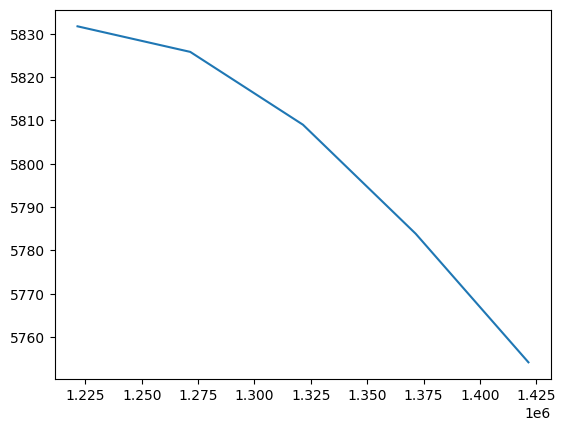

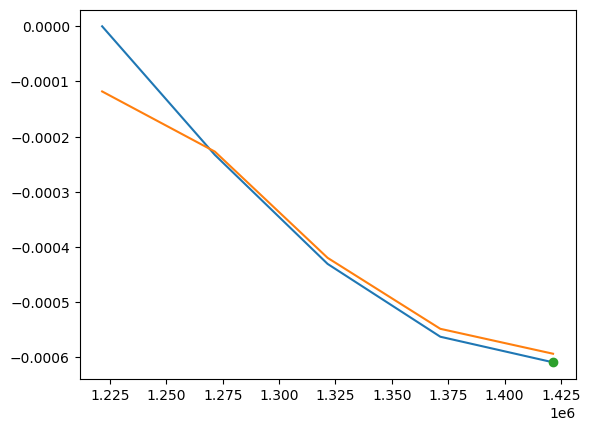

In [11]:
rs = np.linspace(r_icb, r_flayer_top, 5)
norm_rs = (rs-r_icb)/(r_flayer_top-r_icb)*np.pi/2.0
ts = np.cos(norm_rs) * (ta_icb-ta_ftop) + ta_icb
plt.plot(rs, ts)
plt.show()

#dt_dr = ((ta_icb-ta_ftop)*np.pi/2.0 * (np.sin(((np.pi/2.0)*(r_icb-rs))/(r_icb-r_flayer_top)))/(r_icb-r_flayer_top))

dt_dr = -1.0*((ta_icb-ta_ftop)*np.pi/2.0*np.sin(norm_rs))/(r_flayer_top-r_icb)

plt.plot(rs, dt_dr)

plt.plot(rs, np.gradient(ts, rs))
plt.plot(r_flayer_top, -1.0*(ta_icb-ta_ftop)*np.pi/2.0*np.sin(np.pi/2.0)/(r_flayer_top-r_icb), 'o')

In [12]:
def get_poly_t_func(r_icb, r_ftop, t_icb, t_ftop):
    denom = (r_icb - r_ftop)**2
    a = (t_ftop - t_icb)/denom
    b = (-2.0*r_icb * (t_ftop - t_icb))/denom
    c = r_icb**2 * t_ftop - 2 * r_icb * r_ftop * t_icb + r_ftop**2 * t_icb
    c = c / denom
    def poly_t_func(r):
        t = a * r**2 + b * r + c
        return t
    return poly_t_func

In [13]:
temperature_function = layer_setup.fit_quad_func_boundaries(r_icb, r_flayer_top, adiabatic_temperature_function(r_icb)-50.0, adiabatic_temperature_function(r_flayer_top))

In [14]:
composition_function = layer_setup.fit_quad_func_boundaries(r_icb, r_flayer_top, 0.949, xfe_outer_core)

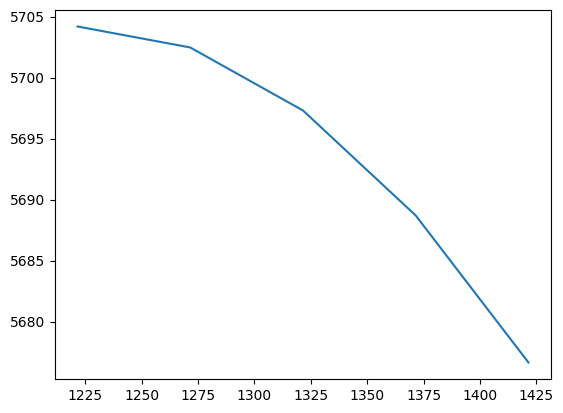

In [15]:
plt.plot(rs/1000, temperature_function(rs))

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Liquid density at ICB: 13094.162907668067 Kg/m^3
Liquid density at top of F-layer 12905.86427152067 Kg/m^3
Liquid density along adiabat at ICB: 13092.292163636042 Kg/m^3
Liquid density along adiabat at top of F-layer 12902.300312084477 Kg/m^3


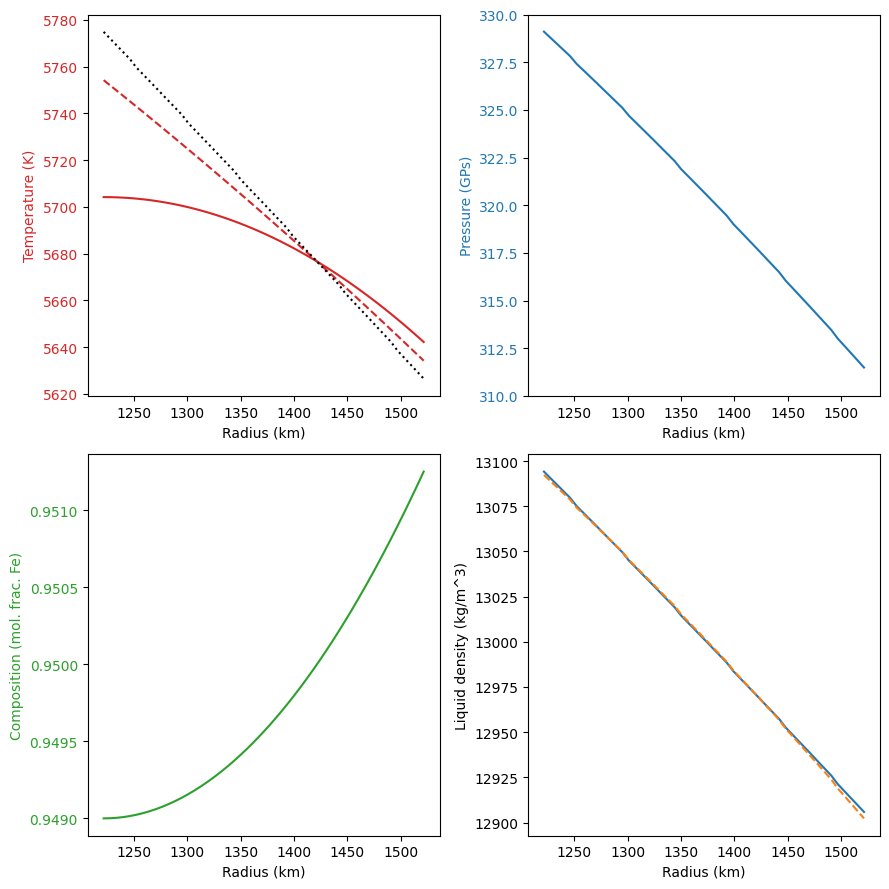

In [16]:
rs = np.linspace(r_icb, r_flayer_top+100.0E3)

# Check PREM works ... and print some interesting values
prem = earth_model.Prem()
print("Pressure at ICB:", prem.pressure(r_icb/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(r_flayer_top/1000.0), "GPa")
print("g at ICB:", prem.gravity(r_icb/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(r_flayer_top/1000.0), "m/s**2")

# Find the liquidus
tl = feot.find_liquidus(composition_function(rs), pressure_function(rs))

# Find the liquid density

liquid_density, _, _, solid_density, _, _ = feot.densities(composition_function(rs), pressure_function(rs),
                                                           temperature_function(rs))

# This is for a well mixed core extended down 
adiabatic_liquid_density, _, _, adiabatic_solid_density, _, _ = feot.densities(xfe_outer_core, pressure_function(rs), 
                                                                               adiabatic_temperature_function(rs))

print("Liquid density at ICB:", liquid_density[0], "Kg/m^3")
print("Liquid density at top of F-layer", liquid_density[-1], "Kg/m^3")
print("Liquid density along adiabat at ICB:", adiabatic_liquid_density[0], "Kg/m^3")
print("Liquid density along adiabat at top of F-layer", adiabatic_liquid_density[-1], "Kg/m^3")


# Plot the F-layer setup alongside the liquidus
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(9,9), tight_layout=True)

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, temperature_function(rs), color=color)
ax1.plot(rs/1000.0, adiabatic_temperature_function(rs), color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])
 

color = 'tab:blue'
ax2.set_xlabel('Radius (km)')
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, pressure_function(rs), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([310, 330])

color = 'tab:green'
ax3.set_xlabel('Radius (km)')
ax3.set_ylabel('Composition (mol. frac. Fe)', color=color)  
ax3.plot(rs/1000.0, composition_function(rs), color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4.set_xlabel('Radius (km)')
ax4.set_ylabel('Liquid density (kg/m^3)')  
ax4.plot(rs/1000.0, liquid_density)
ax4.plot(rs/1000.0, adiabatic_liquid_density, ls='--')
#ax4.plot(rs/1000.0, solid_density, ls=':')
ax4.tick_params(axis='y')

fig.tight_layout()  
plt.show()

In [17]:
Nbv, N2 = layer_setup.estimate_brunt_vaisala_frequency(r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
                                             composition_function, gravity_function, pressure_function)
print(f"BV freq = {Nbv}")

BV freq = 5.811054094293492e-05


In [18]:
import flayer

In [19]:
k0 = 150.0
dl = 1.0E-9
k = 100.0
mu = 1.0E-6
i0 = 1.0E-10
surf_energy = 1.08E-2
wetting_angle = 180.0
hetrogeneous_radius = None

solutions, particle_densities, growth_rate, solid_vf, \
        particle_radius_unnormalised, partial_particle_densities, \
        crit_nuc_radii, nucleation_rates, t_points_out, xl_points_out, total_latent_heat, total_o_rate =flayer.evaluate_flayer(
    temperature_function, composition_function, pressure_function, gravity_function, 0.0, 1.0E20,
                    k0, dl, k, mu, i0, surf_energy, wetting_angle, hetrogeneous_radius,
                    nucleation_radii, analysis_radii, r_icb, 
                    r_flayer_top, verbose=False, silent=False)

print(f"Heat from crystalisation = {total_latent_heat/1.0E12} TW, oxygen = {total_o_rate/1.0E9} Tg/s")

Nucleation calculation
Prefactor: 1e-10 s^-1 m^-3, surface energy 0.0108
Homogenious nucleation
Radius (km), P (GPa), T (K), X (mol. frac Fe), I (s^-1m^-3), r0 (m)
1221.5 329.101 5704.19 0.949 9.86e-11 1.57e-10
1241.7 328.024 5703.91 0.949 9.81e-11 1.81e-10
1261.9 326.939 5703.07 0.949 9.74e-11 2.12e-10
1282.11 325.758 5701.66 0.949 9.63e-11 2.57e-10
1302.31 324.644 5699.69 0.949 9.45e-11 3.13e-10
1322.51 323.516 5697.16 0.949 9.15e-11 3.93e-10
1342.71 322.37 5694.07 0.949 8.58e-11 5.15e-10
1362.91 321.214 5690.42 0.949 7.42e-11 7.19e-10
1383.12 319.963 5686.2 0.95 4.25e-11 1.22e-09
1403.32 318.78 5681.43 0.95 1.38e-12 2.73e-09
Finding 100 IVP solutions


/Users/andreww/Code/slurry/flayer.py:484: RuntimeWarning: invalid value encountered in divide
  mean_particle_velocities[i] = np.mean((partial_densities * partial_velocities) /


Radius (km), P (GPa), Guess T (K), Guess X, dm/dt (kg/s), Q (W/m^3), O prod rate
1221.5 329.101 5704.19 0.949 0 0 0
1241.7 328.024 5703.91 0.94901 6.79e-10 0.000509 9.77e-12
1261.9 326.939 5703.07 0.949041 3.86e-10 0.000289 5.55e-12
1282.11 325.758 5701.66 0.949092 2.04e-10 0.000153 2.94e-12
1302.31 324.644 5699.69 0.949163 9.79e-11 7.35e-05 1.41e-12
1322.51 323.516 5697.16 0.949255 4.07e-11 3.05e-05 5.83e-13
1342.71 322.37 5694.07 0.949367 1.35e-11 1.02e-05 1.94e-13
1362.91 321.214 5690.42 0.9495 3e-12 2.25e-06 4.28e-14
1383.12 319.963 5686.2 0.949653 2.57e-13 1.93e-07 3.65e-15
1403.32 318.78 5681.43 0.949826 2.17e-16 1.63e-10 3.07e-18
Heat from crystalisation = 59.79919133262513 TW, oxygen = 0.0011472878377006687 Tg/s


So - what we are going to do is:

1. sum up Q
2. Match total Q with heat flux out of CMB. This gives us an upper bound on what Q can be, as we should add the secular cooling and the gravitational mixing from  light emement release. However, an upper bound is probably all we need as the constraint will be strong!
